# Tanzanian Water Well Dysfunction

## Overview

The machine learning model developed for this project will be trained to classify water pumps into one of three categories: functional, in need of repairs, or non-functional. The predictions made by the model will include identifying non-functional pumps, thus aiding in prioritizing maintenance efforts to address issues promptly and ensure a sustainable and reliable water supply for communities.

## Business Understanding

In Tanzania, ensuring the accessibility and functionality of water pumps is vital for delivering clean and potable water to communities. Many rural areas rely on these pumps for their water supply. However, issues such as pump malfunctions and breakdowns can lead to water scarcity, impacting public health, agriculture, and overall community well-being.

The primary goal of this project is to develop a predictive maintenance model for water pumps, enabling proactive identification of pumps at risk of dysfunctionality. By leveraging machine learning, we aim to optimize maintenance operations, prioritize interventions, and minimize downtime for non-functional pumps.

## Modeling

In [83]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency , skew

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.ensemble import RandomForestClassifier

### Suppress Warnings:
import warnings
warnings.filterwarnings('ignore')


Load clean data set


In [4]:
#load clean data set
featurs=features =pd.read_csv('../Data/clean_data.csv' , index_col=0)

In [5]:
#casting the data type of region and district code to object , they need to be catagorical
features['region_code'] = features['region_code'].astype('O')
features['district_code'] = features['district_code'].astype('O')

### column 'status_group' is the target

    class 0 Funcional
    class 2 non functional
    class 1 Functional , needs repair

In [6]:
features.status_group.value_counts(normalize=True)

functional                 0.547146
non functional             0.386622
functional needs repair    0.066232
Name: status_group, dtype: float64

#### Assesses whether there is a significant association between  categorical features and target using contigency table

In [7]:
features_columns = features.select_dtypes(include='O').columns.difference(['status_group'])
cramer_vs = []

for cols in features_columns:
    contingency_table = pd.crosstab(features['status_group'], features[cols])

    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    v = np.sqrt(chi2 / (n * min_dim))
    cramer_vs.append(v)
    print(f"Cramér's V for {cols}: {v * 100}")

Cramér's V for basin: 14.039942653092838
Cramér's V for district_code: 12.176885873667215
Cramér's V for extraction_type: 25.434636897093572
Cramér's V for extraction_type_class: 24.849463118163044
Cramér's V for funder: 35.6261047492305
Cramér's V for lga: 31.364730334510778
Cramér's V for management: 12.92057939302078
Cramér's V for payment_type: 18.661209409437916
Cramér's V for quantity: 30.497883605923825
Cramér's V for region_code: 22.005631106048735
Cramér's V for source: 15.293703460470764
Cramér's V for source_class: 7.65176145463199
Cramér's V for water_quality: 10.950805868666057
Cramér's V for waterpoint_type: 25.094313551495873


In [8]:
contingency_table

waterpoint_type,cattle trough,communal standpipe,communal standpipe multiple,dam,hand pump,improved spring,other
status_group,,,,,,,
functional,65,15033,2087,6,8994,528,722
functional needs repair,2,1761,632,0,592,76,258
non functional,19,7121,2829,0,4918,116,4383


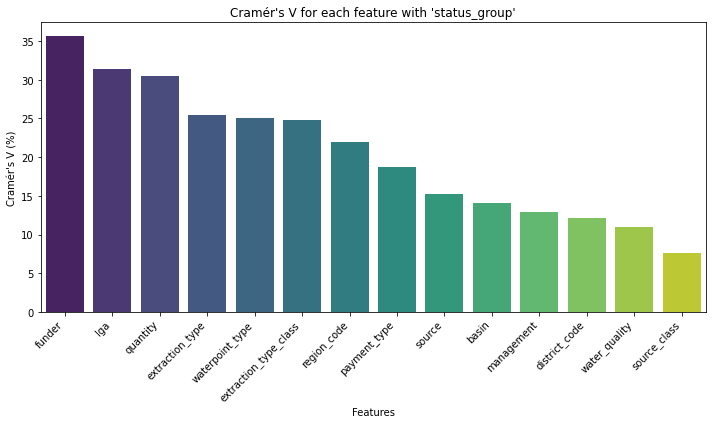

In [9]:
data = pd.DataFrame({'Features': features_columns, "Cramér's V (%)": [v * 100 for v in cramer_vs]})
data = data.sort_values(by="Cramér's V (%)", ascending=False)

colors = sns.color_palette("viridis", n_colors=len(data))

# Plot using Seaborn with sorted and colored bars
plt.figure(figsize=(10, 6))
sns.barplot(x='Features', y="Cramér's V (%)", data=data, palette=colors)
plt.xlabel('Features')
plt.ylabel("Cramér's V (%)")
plt.title("Cramér's V for each feature with 'status_group'")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



Assesses whether there is a significant association between numerical features and target

## Modeling

simple cross validation function for pipelines

In [94]:
def cross_validate_pipelines(model, X, y, cv=5, scoring='recall_macro'):
    
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)

    return (np.mean(scores)) 

In [11]:
#numerical and catagorical columns
cat_columns=list(features.select_dtypes(include='O').columns)
num_columns=list(features.select_dtypes(exclude='O').columns)
cat_columns.remove('status_group')

check the skewnes of the numerical features

In [12]:
# numeric_cols = features.select_dtypes(include=['float64', 'int64']).columns

# skewness = features[num_columns].apply(lambda x: skew(x.dropna()))
# skewed_columns = skewness[abs(skewness) > 0.5].index.tolist()

# skewed_columns =['amount_tsh','population']
# print("Skewed Columns:", skewed_columns)

split train and test data and label encode target 

    0 Functional
    1 non functional
    2 functional needs repair

In [13]:
# create features and target
X = features.drop('status_group', axis=1)
y = features.status_group

#label encode for the classes of the target
encoder = LabelEncoder()
y_transorm = encoder.fit_transform(y)


# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_transorm, test_size=0.2, random_state=42)

### sub-pipelines

In [14]:
num_pipeline = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='median' ,add_indicator=True)),
    ('ss', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('impute_cat', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore',sparse=True))
])

In [15]:
col_trans=ColumnTransformer(transformers=[
    ('nums', num_pipeline, num_columns),
    ('cats', cat_pipeline, cat_columns),
], remainder='passthrough' ,n_jobs=-1 )

# Model 1

#### Dummy Classifier

In [16]:
dummy_pipeline = Pipeline([
    ('col_trans', col_trans),
    ('dummyC', DummyClassifier())
])

dummy_pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'public_meeting', 'permit',
                                                   'age_waterpoint']),
           

The accuracy of the cross validaion of dummy classifier is 45.15%

In [89]:
cross_validate_pipelines(dummy_pipeline , X_test , y_test)

0.4583713696814793

In [18]:
dummy_pipeline.score(X_train , y_train)

0.4509759928202827

In [19]:
y_test_pred = dummy_pipeline.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.56      0.55      0.55      5523
           1       0.07      0.07      0.07       686
           2       0.38      0.39      0.39      3820

    accuracy                           0.46     10029
   macro avg       0.34      0.34      0.34     10029
weighted avg       0.46      0.46      0.46     10029



## Logistic Regression

logistic regression model 1


In [20]:
# first simple model
logreg_model1 = Pipeline([
    ('colt', col_trans),
    ('logreg', LogisticRegression(C=0.1))
])

logreg_model1.fit(X_train, y_train)

Pipeline(steps=[('colt',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'public_meeting', 'permit',
                                                   'age_waterpoint']),
                

In [21]:
cross_validate_pipelines(logreg_model1 , X_train , y_train)

0.7621719537133533

In [22]:
logreg_model1.score(X_train , y_train)

0.7693266522075137

In [23]:
y_lgtest_pred = logreg_model1.predict(X_test)
print(classification_report(y_test, y_lgtest_pred))

              precision    recall  f1-score   support

           0       0.76      0.90      0.82      5523
           1       0.65      0.12      0.21       686
           2       0.80      0.70      0.74      3820

    accuracy                           0.77     10029
   macro avg       0.73      0.57      0.59     10029
weighted avg       0.76      0.77      0.75     10029



Logistic regression model one seems doing better than dummy classifier
    where its accuracy is 77% but failed to pick up the disfunctionality of the well.

##### Logistic regression adjusting hyper parameters

In [24]:
logreg_model2 = Pipeline([
    ('colt', col_trans),
    ('logreg', LogisticRegression(class_weight='balanced' ,C=1 ,n_jobs=-1 , solver='liblinear',max_iter=1000, tol=0.001))
])

logreg_model2.fit(X_train, y_train)

Pipeline(steps=[('colt',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'public_meeting', 'permit',
                                                   'age_waterpoint']),
                

recall percentage

In [25]:
cross_validate_pipelines(logreg_model2 , X_train , y_train)

0.7353478078621694

In [26]:
logreg_model2.score(X_train , y_train)

0.7490838381572059

In [27]:
y_test_pred = logreg_model2.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      5523
           1       0.30      0.47      0.36       686
           2       0.78      0.70      0.74      3820

    accuracy                           0.74     10029
   macro avg       0.63      0.66      0.63     10029
weighted avg       0.76      0.74      0.75     10029



## model feature selector

    using select from model to maximize my model by minimizing complexity
    
    This model recall score on unseen data is 

           functional                78%     
           non functional            41%      
           fuctional needs repair    67% 
it is not picking to much of non fucntional class       

In [28]:
from sklearn.feature_selection import SelectFromModel

logreg_model4 = Pipeline([
    ('colt', col_trans),
    ('selector', SelectFromModel(LogisticRegression(class_weight='balanced' ,C=1 ,n_jobs=-1 , solver='liblinear',max_iter=1000, tol=0.001))),
    ('logreg', LogisticRegression(class_weight='balanced' ,C=1 ,n_jobs=-1 , solver='liblinear',max_iter=1000, tol=0.001))
])

logreg_model4.fit(X_train, y_train)

Pipeline(steps=[('colt',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'public_meeting', 'permit',
                                                   'age_waterpoint']),
                

In [29]:
cross_validate_pipelines(logreg_model4 , X_train , y_train)

0.7304864943106568

In [30]:
y_test_pred4 = logreg_model4.predict(X_test)
print(classification_report(y_test, y_test_pred4))

              precision    recall  f1-score   support

           0       0.78      0.81      0.80      5523
           1       0.28      0.41      0.34       686
           2       0.78      0.67      0.72      3820

    accuracy                           0.73     10029
   macro avg       0.61      0.63      0.62     10029
weighted avg       0.75      0.73      0.74     10029



### Random Forest Classification

randome forest classification first model

randome forest classification secod model after grid search

In [52]:
randomF_model = Pipeline([
    ('colt', col_trans),
    ('logreg', RandomForestClassifier(class_weight='balanced',min_samples_split=6,min_samples_leaf=4,n_estimators=100, random_state=42))
])

randomF_model.fit(X_train, y_train)

Pipeline(steps=[('colt',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'public_meeting', 'permit',
                                                   'age_waterpoint']),
                

In [56]:
cross_validate_pipelines(randomF_model , X_train , y_train)

0.7153791954339204

In [53]:
randomF_model.score(X_train , y_train) , randomF_model.score(X_test , y_test) 

(0.7472889088325481, 0.7239006880047861)

In [57]:
y_test_pred=randomF_model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.72      0.77      5523
           1       0.27      0.73      0.40       686
           2       0.81      0.73      0.77      3820

    accuracy                           0.72     10029
   macro avg       0.64      0.73      0.65     10029
weighted avg       0.79      0.72      0.75     10029



##### confussion matrix for random forest


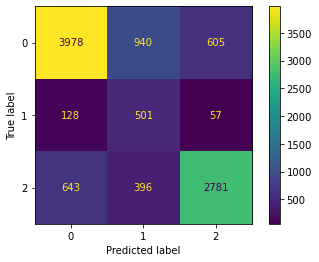

In [58]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Grid search 1 for random forest classification

In [42]:
param_grid = {
    'logreg__n_estimators': [50, 100, 200],
    'logreg__max_depth': [None, 10, 20],
    'logreg__min_samples_split': [2, 4, 6],
    'logreg__min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(randomF_model, param_grid, cv=5, scoring='recall_macro',n_jobs = -1)
grid_search.fit(X_train, y_train)


print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'logreg__max_depth': None, 'logreg__min_samples_leaf': 2, 'logreg__min_samples_split': 6, 'logreg__n_estimators': 50}
Best Cross-Validation Score: 0.7212781275982877


### Feature importance

feature importance from random fores classification

In [62]:
colt = randomF_model.named_steps['colt']
num_trans = colt.transformers_[0][2]
cat_trans = colt.transformers_[1][2]
feature_names = num_trans +cat_trans

In [63]:
rf_classifier = randomF_model.named_steps['logreg']
feature_importances = rf_classifier.feature_importances_
print("Feature Importances:")
feature_importance_df=pd.DataFrame()
for feature, importance in zip(feature_names, feature_importances):
    feature_importance_df=feature_importance_df.append({'Feature': feature, 'Importance': importance}, ignore_index=True)
    print(f"{feature}: {importance}")

Feature Importances:
amount_tsh: 0.015430756508458692
gps_height: 0.03315706721267188
longitude: 0.05462324027827048
latitude: 0.04384837659721539
num_private: 0.0007588353320696995
population: 0.021444769129355223
public_meeting: 0.0036912609644967577
permit: 0.006857458912573693
age_waterpoint: 0.03226450753623995
funder: 0.014652346717858082
basin: 0.005089316075256608
region_code: 0.0004578918905074867
district_code: 0.004806694718719384
lga: 3.9677673228189545e-05
extraction_type: 4.4675659081925987e-05
extraction_type_class: 0.0
management: 2.268323968031746e-05
payment_type: 0.0
water_quality: 0.0
quantity: 0.0
source: 0.0
source_class: 2.90412664187028e-05
waterpoint_type: 0.0


ploting heatmap on top 8 important features from the random forest model

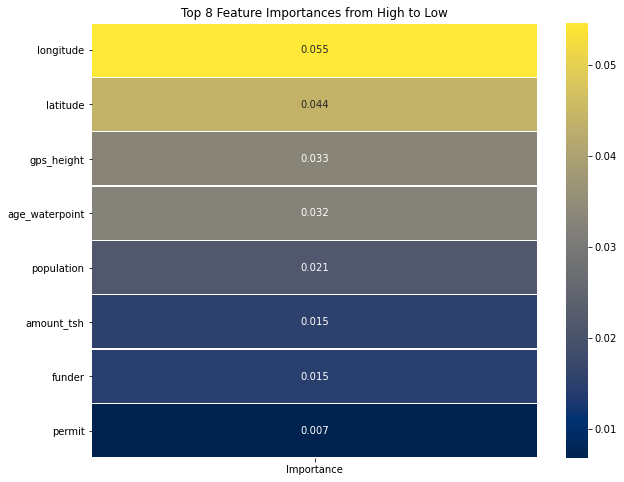

In [64]:

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_features_df = feature_importance_df.head(8)

plt.figure(figsize=(10, 8))
sns.heatmap(data=top_features_df[['Importance']], annot=True, cmap='cividis', fmt=".3f", linewidths=.5, yticklabels=top_features_df['Feature'])
plt.title('Top 8 Feature Importances from High to Low')
plt.show()


## Decision tree

In [76]:
dt_classifier = DecisionTreeClassifier(
    class_weight='balanced',
    max_depth=10,
    min_samples_split=6,
    min_samples_leaf=4,
    random_state=42
)

dt_pipe = Pipeline([
    ('colt', col_trans),
    ('dt', dt_classifier)
])

dt_pipe.fit(X_train, y_train)

Pipeline(steps=[('colt',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'public_meeting', 'permit',
                                                   'age_waterpoint']),
                

In [78]:
dt_pipe.score(X_train , y_train) , dt_pipe.score(X_test , y_test)

(0.691047789993269, 0.6605843055140094)

In [77]:
y_test_pred2=dt_pipe.predict(X_test)
print(classification_report(y_test, y_test_pred2)) 

              precision    recall  f1-score   support

           0       0.80      0.66      0.73      5523
           1       0.21      0.72      0.32       686
           2       0.81      0.64      0.72      3820

    accuracy                           0.66     10029
   macro avg       0.61      0.68      0.59     10029
weighted avg       0.76      0.66      0.69     10029



### Grid search for decision tree

In [75]:
param_grid = {
    'dt__max_depth': [5, 10, 15],
    'dt__min_samples_split': [2, 4, 6],
    'dt__min_samples_leaf': [2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=dt_pipe,
    param_grid=param_grid,
    scoring='recall_macro',  
    cv=5,  
    n_jobs=-1 
)

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_dt_model = grid_search.best_estimator_
best_dt_model.fit(X_train, y_train)


Best Hyperparameters: {'dt__max_depth': 15, 'dt__min_samples_leaf': 6, 'dt__min_samples_split': 2}


Pipeline(steps=[('colt',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'public_meeting', 'permit',
                                                   'age_waterpoint']),
                

changing the hyperparameter for the best hyperparameter choosen by the grid search

In [80]:
dt_classifier = DecisionTreeClassifier(
    class_weight='balanced',
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=6,
    random_state=42
)

dt_pipe2 = Pipeline([
    ('colt', col_trans),
    ('dt', dt_classifier)
])

dt_pipe2.fit(X_train, y_train)

Pipeline(steps=[('colt',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'public_meeting', 'permit',
                                                   'age_waterpoint']),
                

In [82]:
dt_pipe2.score(X_train , y_train) , dt_pipe2.score(X_test , y_test)

(0.691047789993269, 0.6605843055140094)

In [81]:
y_test_pred2=dt_pipe2.predict(X_test)
print(classification_report(y_test, y_test_pred2)) 

              precision    recall  f1-score   support

           0       0.80      0.66      0.73      5523
           1       0.21      0.72      0.32       686
           2       0.81      0.64      0.72      3820

    accuracy                           0.66     10029
   macro avg       0.61      0.68      0.59     10029
weighted avg       0.76      0.66      0.69     10029



### KNN


In [70]:
knn_pipe = Pipeline([
    ('colt', col_trans),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

knn_pipe.fit(X_train, y_train)


Pipeline(steps=[('colt',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'public_meeting', 'permit',
                                                   'age_waterpoint']),
                

In [71]:
knn_pipe.score(X_train , y_train)

0.8397776282003341

In [72]:
y_test_pred2=knn_pipe.predict(X_test)
print(classification_report(y_test, y_test_pred2)) 

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      5523
           1       0.51      0.30      0.38       686
           2       0.80      0.73      0.76      3820

    accuracy                           0.78     10029
   macro avg       0.70      0.63      0.65     10029
weighted avg       0.77      0.78      0.77     10029



#### addining class balance weight to KNN

In [73]:
knn_pipe2 = Pipeline([
    ('colt', col_trans),
    ('knn', KNeighborsClassifier(n_neighbors=6,weights='distance'))
])

knn_pipe2.fit(X_train, y_train)


Pipeline(steps=[('colt',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'public_meeting', 'permit',
                                                   'age_waterpoint']),
                

In [74]:
y_test_pred2=knn_pipe2.predict(X_test)
print(classification_report(y_test, y_test_pred2)) 

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      5523
           1       0.47      0.34      0.40       686
           2       0.79      0.76      0.78      3820

    accuracy                           0.78     10029
   macro avg       0.69      0.65      0.67     10029
weighted avg       0.78      0.78      0.78     10029



### KNN with smote

In [86]:
from imblearn.pipeline import Pipeline
knn_pipe_with_smote = Pipeline([
    ('colt', col_trans),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance'))  # Adjust n_neighbors and weights as needed
])
knn_pipe_with_smote.fit(X_train, y_train)

Pipeline(steps=[('colt',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'public_meeting', 'permit',
                                                   'age_waterpoint']),
                

In [87]:
knn_pipe_with_smote.score(X_train , y_train) , knn_pipe_with_smote.score(X_test , y_test)

(1.0, 0.746036494166916)

In [88]:
y_test_pred2=knn_pipe_with_smote.predict(X_test)
print(classification_report(y_test, y_test_pred2)) 

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      5523
           1       0.31      0.54      0.40       686
           2       0.77      0.76      0.77      3820

    accuracy                           0.75     10029
   macro avg       0.64      0.69      0.65     10029
weighted avg       0.77      0.75      0.76     10029



In [97]:
results = {
    'Logistic Regression': cross_validate_pipelines(logreg_model4 , X_test , y_test),
    'Random Forest': cross_validate_pipelines(randomF_model, X_test , y_test),
    'Decision Tree': cross_validate_pipelines(dt_pipe2 , X_test , y_test),
    'KNN': cross_validate_pipelines(knn_pipe2, X_test , y_test)
}

In [98]:
results

{'Logistic Regression': 0.6158098957495801,
 'Random Forest': 0.6652383382271119,
 'Decision Tree': 0.620303577971482,
 'KNN': 0.583294180399043}

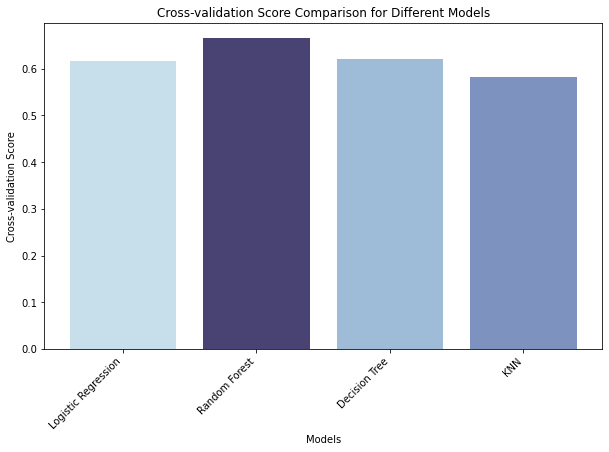

In [99]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#c7dfeb', '#494373', '#9ebbd7', '#7d92bf']
plt.bar(results.keys(), results.values(), color=colors)
plt.xlabel('Models')
plt.ylabel('Cross-validation Score')
plt.title('Cross-validation Score Comparison for Different Models')
plt.xticks(rotation=45, ha="right")

plt.show()


# conclusion 

Our winning model is random foresr classification where it caches up well for the dysfunctional of the well.

In [100]:
y_test_pred=randomF_model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.72      0.77      5523
           1       0.27      0.73      0.40       686
           2       0.81      0.73      0.77      3820

    accuracy                           0.72     10029
   macro avg       0.64      0.73      0.65     10029
weighted avg       0.79      0.72      0.75     10029



### Functional 72%
### None Functional 73%
### Functional needs repair 73% 

### with overall score of 72%

# Recommendation 1

Enhance the impact of our initiative, we strongly recommend active community involvement and dedicated efforts toward raising awareness. Engaging with local communities is pivotal for the success of any project aiming to address water-related challenges. Establishing partnerships with community leaders, organizations, and local influencers will foster a sense of ownership and shared responsibility. 


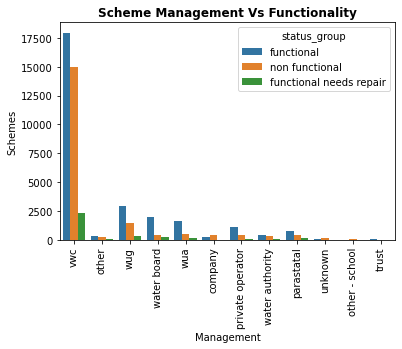

In [102]:
ax = sns.countplot(x='management', hue='status_group', data=features)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
ax.set_xlabel('Management')  # Use set_xlabel instead of plt.xlabel
ax.set_ylabel('Schemes')      # Use set_ylabel instead of plt.ylabel
ax.set_title('Scheme Management Vs Functionality', fontsize=12, fontweight='bold');

# Recommendation 2

Establishing a comprehensive preventive maintenance program involves regular inspections, routine assessments, and timely repairs. This initiative not only addresses minor issues before they escalate but also extends the lifespan of the wells, reducing the likelihood of major breakdowns.


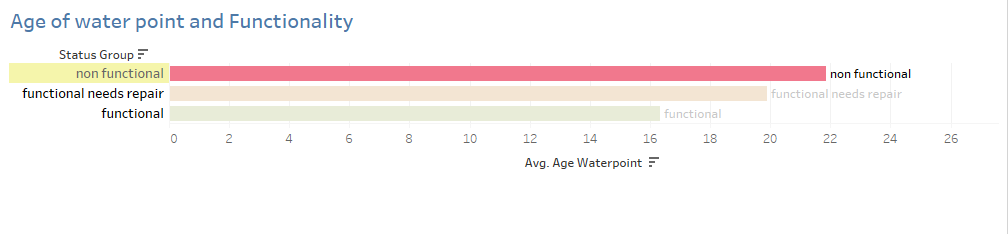

In [107]:
from IPython.display import Image, display
img_path = '../Images/age.PNG' 
img = Image(filename=img_path)
display(img)

# Recommendation 3

Our third recommendation emphasizes the adoption and implementation of a predictive model that exhibits commendable recall scores across all classes. This model, boasting a recall score of 72% for the "Functional" class, 73% for the "Non-Functional" class, and another 73% for the "Functional Needs Repair" class, demonstrates its effectiveness in correctly identifying and classifying instances within each category. A high recall score signifies the model's capability to capture a significant portion of the true positive cases, minimizing the chances of overlooking critical issues. By embracing this model, we can enhance our ability to identify and address water pump functionality concerns promptly.


In [108]:
y_test_pred=randomF_model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.72      0.77      5523
           1       0.27      0.73      0.40       686
           2       0.81      0.73      0.77      3820

    accuracy                           0.72     10029
   macro avg       0.64      0.73      0.65     10029
weighted avg       0.79      0.72      0.75     10029



# Next steps

- Improve model
- Look into the depth of well
- Geographical impacts